In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# feature engineering and cleaning

In [4]:
# the length of the name
train['Name_length'] = train['Name'].apply(len)

# if a passenger had a cabin on the ship
# warn here:type(x)==float is for examinate the exit of NaN(NaN is float type)
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if(type(x) ==float) else 1)

test['Name_length'] = test['Name'].apply(len)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# create some features about family members
# use all train data and test data
full_data = [train,test]

# get the number of member in the same family
for dataset in full_data:
#     dataset['Family_Size'] = dataset['SibSp'] + dataset['Parch']+1
    dataset['Family_Size'] = dataset['SibSp'] + dataset['Parch'] + 1

# get the detail infomation
for dataset in full_data:
    dataset['Is_Alone'] = 0
    dataset.loc[dataset['Family_Size']==1,'Is_Alone'] = 1
    
# deal with NaN
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

    
for dataset in full_data:
#     here why only count train dataset 
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# discretizetion on Fare feature(why only trainset counts)
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    
    age_null_count = dataset['Age'].isnull().sum()
#     create some number from uniform distribution to fill null entries
    arg_null_random_list = np.random.randint(age_avg - age_std,age_avg + age_std ,size=age_null_count)
#     why here modify test dataset
# note here: use loc rather than [] directly , otherwise it may not change the value due to that it just a copy of the origin dataframe
    dataset.loc[np.isnan(dataset['Age']),'Age'] = arg_null_random_list
#     discretizetion
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'],5)

# Then we can extra some information from name of passenger

# extract titles of passenger names
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

#     do discretezetion on name(use 'rare' to replace the rare name)
# It is more convient to convert to number
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
        'rare')
#     normalization on names(use common names more often)
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

# map strings to discrete integrates
for dataset in full_data:
#     all data use int type
#     dataset['Sex'] = dataset['Sex'].map({'female':0,'male':1}).astype(int)
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Title'] = dataset['Title'].astype(int)
    
#     I think that it can not be calculated directly by using these number here 
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
#     for Fare
# why use the same creterian on both train dataset and test dataset
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						= 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
#     for Age

    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [8]:
# drop some features
drop_elements = ['Name','Ticket','Cabin','PassengerId']
train.drop(drop_elements,axis=1,inplace=True)
train.drop(['CategoricalAge','CategoricalFare'],axis=1,inplace=True)
test.drop(drop_elements,axis=1,inplace=True)

* display the transformed dataset

In [9]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length,Has_Cabin,Family_Size,Is_Alone,Title
0,0,3,1,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,1,0,3,1,51,1,2,0,3
2,1,3,0,1,0,0,1,0,22,0,1,1,2
3,1,1,0,2,1,0,3,0,44,1,2,0,3
4,0,3,1,2,0,0,1,0,24,0,1,1,1


# Visualisation

In [11]:
import seaborn as sns

##  heatmap

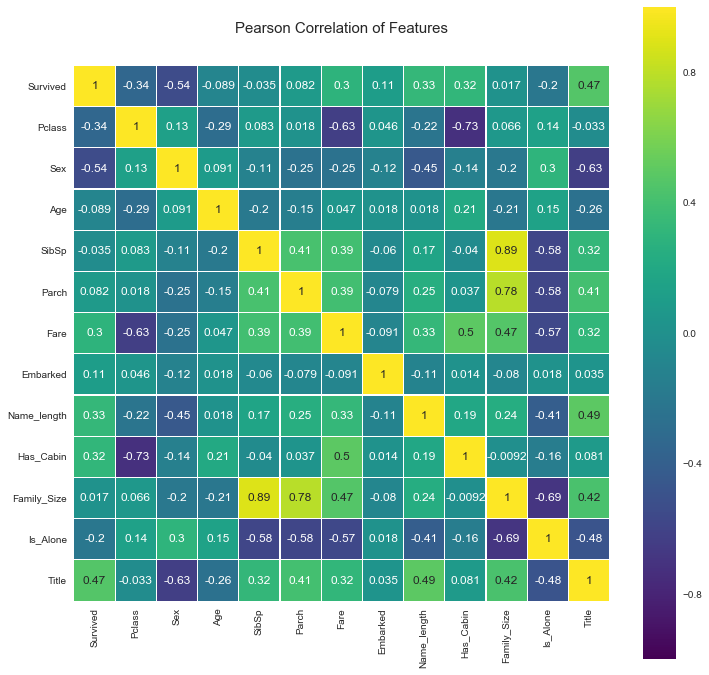

In [16]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
           annot=True)
plt.show()

## pairplots

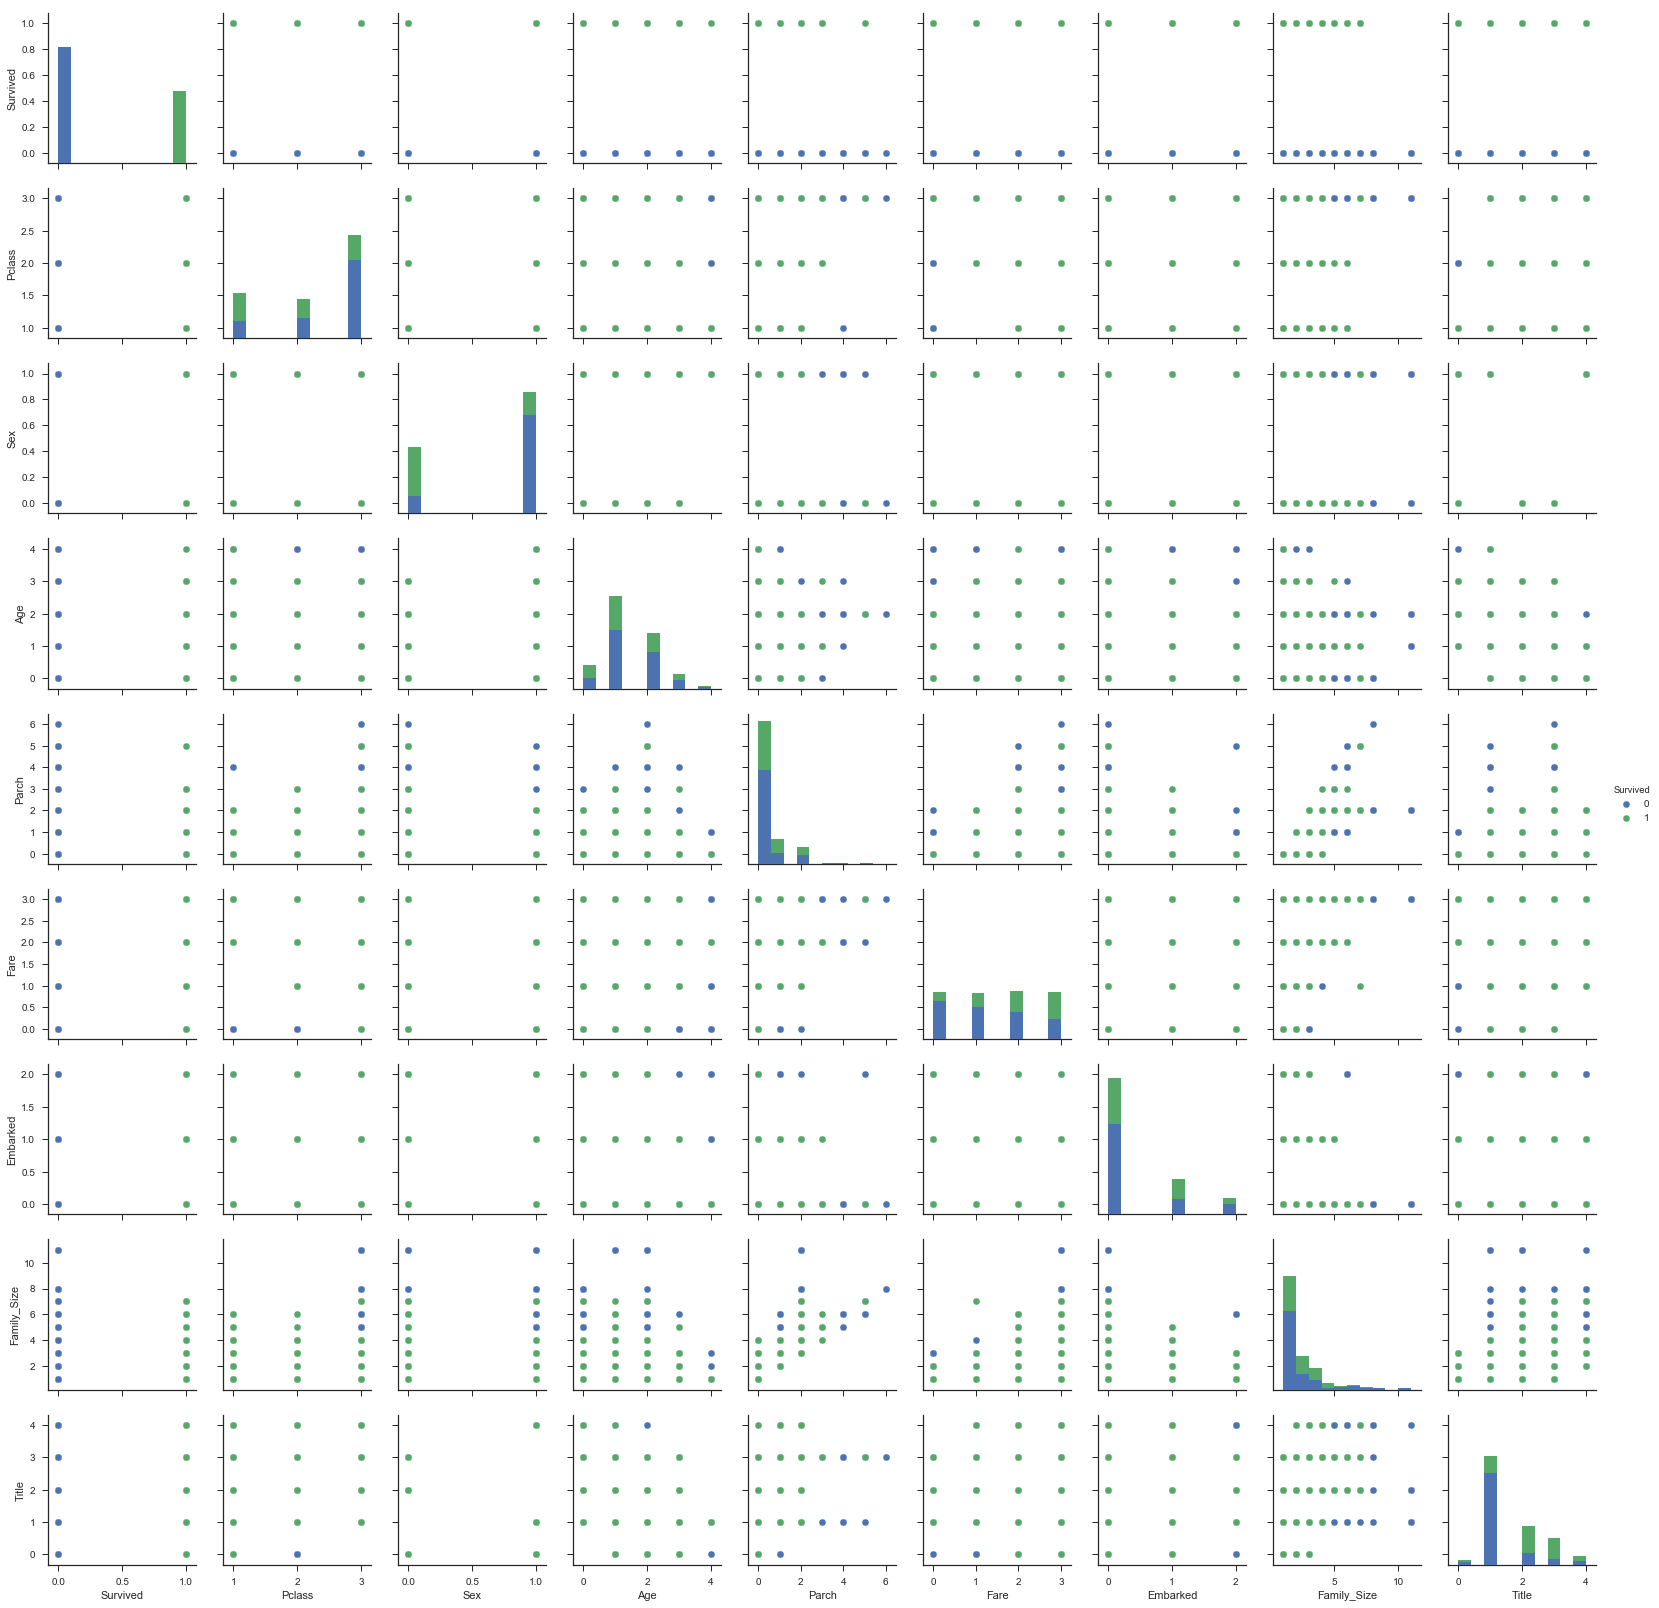

In [31]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',u'Family_Size', u'Title']],
             hue='Survived')
sns.plt.show()

# ensembling and stacking models

In [32]:
train.values?